In [1]:
import pandas as pd

In [2]:
import os
from os import listdir, system

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

print("Parent Directory:", parent_dir)

Parent Directory: /gpfs/fs1/home/j/jparkin/wongkoji/PathwayCompleteness


In [3]:
def clean_ec_data(ec_number):
    """cleans ec data"""
    if not ec_number:
        return "None"
    if '-' in ec_number:
        return "None"
    # TODO: split these
    elif ';' in ec_number:
        return "None"
    else:
        return ec_number

In [12]:
deepec_df.dropna()

,sequence_ID,prediction
8,lcl|NZ_CP014158.1_cds_WP_082816238.1_5-2/1,EC:2.7.1.21;EC:3.6.4.12
9,lcl|NZ_CP014158.1_cds_WP_043313934.1_4-4/1,EC:5.6.2.2
10,lcl|NZ_CP014158.1_cds_WP_070065483.1_7-4/1,EC:2.7.7.6
15,lcl|NZ_CP014158.1_cds_WP_052267673.1_9-2/1,EC:1.1.1.262;EC:4.1.2.14
24,lcl|NZ_CP014158.1_cds_WP_058487941.1_17-4/1,EC:3.6.3.-
...,...,...
38805,lcl|NZ_CP141948.1_cds_WP_058488961.1_6134-4/1,EC:4.1.1.23
38806,lcl|NZ_CP141948.1_cds_WP_058488961.1_6134-2/1,EC:4.1.1.23
38826,lcl|NZ_CP141948.1_cds_WP_009621471.1_6155-4/1,EC:3.6.3.14
38827,lcl|NZ_CP141948.1_cds_WP_009621471.1_6155-2/1,EC:3.6.3.14


In [16]:
deepec_dict = {}
deepec_dir = "/scratch/j/jparkin/wongkoji/deepec_outputs2/"
entries = listdir(deepec_dir)
all_ec_df = pd.DataFrame()
total = 0
present_total = 0

for entry in entries:
    deepec_file = f"{deepec_dir}{entry}/DeepECv2_result.txt"
    deepec_df = pd.read_csv(deepec_file, sep='\t')
    total += len(deepec_df)
    deepec_df = deepec_df.dropna()
    # Drop any unannotated reads
    deepec_df = deepec_df[deepec_df['prediction'] != 'None']
    
    # clean up formats of EC data
    deepec_df['prediction'] = deepec_df['prediction'].apply(clean_ec_data)
    # format ECs with lowercase for KEGG API
    deepec_df['prediction'] = deepec_df['prediction'].apply(str.lower)
    key = entry.replace("deepEC_", "")
    deepec_dict[key] = deepec_df
    present_total += len(deepec_df)
entries = [s.replace("deepEC_", "") for s in entries]

enzymes_annotated_percent = present_total / total
print("percent of reads annotated:", enzymes_annotated_percent * 100)
print("number of reads after translation:", total)
print("number of reads after filtering deepEC:", present_total)

percent of reads annotated: 13.419172450004227
number of reads after translation: 674207
number of reads after filtering deepEC: 90473


In [ ]:
deepec_dict["321846"].groupby("prediction").size()

prediction
ec:1.1.1.1         1
ec:1.1.1.100      10
ec:1.1.1.108       6
ec:1.1.1.122       2
ec:1.1.1.132       3
                ... 
ec:7.6.2.11       12
ec:7.6.2.5         6
ec:7.6.2.7         5
ec:7.6.2.9         2
none            1396
Length: 991, dtype: int64

In [ ]:
total_reads = 0
for taxon in deepec_dict:
    total_reads += len(deepec_dict[taxon])

In [ ]:
# LOADING IN OUR DATABASES AS DATAFRAMES

# creating a df for our ecs
enzymes_file = os.path.join(parent_dir, "db/enzymes_ec.tsv")
enzymes_df = pd.read_csv(enzymes_file, delimiter='\t', names=["ec", "name"])
# creating a df for our pathways
pathways_file = os.path.join(parent_dir, "db/pathways_ec.tsv")
pathways_df = pd.read_csv(pathways_file, delimiter='\t', names=["pathway", "function"])

# load in our ec-pathways relationship
import json
json_file = open(os.path.join(parent_dir, "db/pathways.json"), "r")
ec_paths = json.load(json_file)

# load in dataframe that shows which pathways have which enzymes
paths_to_ec_df = pd.read_csv(os.path.join(parent_dir, "db/pathways_ecs.csv"))

In [ ]:
def get_pathways(ec_id, df: pd.DataFrame):
    """get a list of pathways given an EC number in format ec:#.#.#.#"""
    if "ec:" not in ec_id:
        raise NameError
    return list(df[df['ec'] == ec_id]['pathway'])

def get_enzymes(pathway_id, df: pd.DataFrame):
    """get a list of enzymes given a KEGG pathway in format ec#####"""
    return list(df[df['pathway'] == pathway_id]['ec']) 

In [ ]:
# to get all the ecs for a pathway
paths_to_ec_df[paths_to_ec_df['pathway'] == "ec00970"].head()
# to get all the pathways for an ec
paths_to_ec_df[paths_to_ec_df['ec'] == "ec:1.1.1.3"].head()

,pathway,ec
96,ec01100,ec:1.1.1.3
2866,ec01110,ec:1.1.1.3
4186,ec01120,ec:1.1.1.3
6759,ec00260,ec:1.1.1.3
6829,ec00270,ec:1.1.1.3


In [ ]:
ec_pathways_dict = {}
# Finds pathways an enzyme is present in within half a second
def find_pathways_opt(ec_number, ec_pathways_dict):
    """Finds pathways an enzyme is present

    Args:
        ec_number (str): must be a valid Enzyme Commission number

    Returns:
        list of pathways
    """
    if 'ec' not in ec_number:
        ec_number = f"ec:{ec_number}"
    pathways = get_pathways(ec_number, paths_to_ec_df)
    for path in pathways:
        if path not in ec_pathways_dict:
            ec_pathways_dict[path] = [ec_number]
        else:
            ec_pathways_dict[path].append(ec_number)
    return ec_pathways_dict

In [ ]:
# from Bio.KEGG.REST import kegg_link
import re
# Note: some ecs don't have a corresponding pathway such as ec:1.4.3.11
# calculate_pathway_completeness("ec00300", ec_pathways_dict)

# now we can calculate pathway completeness
def calculate_pathway_completeness(pathway_of_interest, ec_pathways):
    if pathway_of_interest not in ec_pathways:
        print(f"Pathway {pathway_of_interest} not present in dictionary.")
        return
    if pathway_of_interest not in list(paths_to_ec_df['pathway']):
        print(f"Pathway {pathway_of_interest} not present in DataFrame.") 
        return
    
    # Get the list of EC numbers involved in the pathway of interest
    total_enzymes = set(get_enzymes(pathway_of_interest, paths_to_ec_df))
    present_enzymes = list(set(ec_pathways[pathway_of_interest]))
    # print(present_enzymes)
    
    try:
        completeness = len(present_enzymes) / len(total_enzymes)
        return completeness
    except ZeroDivisionError as e:
        print(pathway_of_interest)
        print("division by zero, is the pathway of interest formatted correctly? (eg. 'ec00300')")
        return

# brute force
def calculate_all_paths_completeness(ec_pathways_dict):
    pathway_completeness = {}
    for path in ec_pathways_dict:
        if path not in pathway_completeness:
            pathway_completeness[path] = calculate_pathway_completeness(path, ec_pathways_dict)
    return pathway_completeness



In [ ]:
present_dict = {}
for entry in entries:
    deepec_df = deepec_dict[entry]
    present_enzymes = list(set(deepec_df['prediction']))
    ec_pathways_dict = {}
    for ec in present_enzymes:
        find_pathways_opt(ec, ec_pathways_dict)
    key = entry.replace("deepEC_", "")
    present_dict[key] = ec_pathways_dict
print(present_dict[key])

{'ec01100': ['ec:1.11.1.6', 'ec:2.7.7.18', 'ec:3.2.1.18', 'ec:2.4.1.109', 'ec:1.4.1.4', 'ec:1.7.2.2', 'ec:4.1.3.4', 'ec:2.7.1.148', 'ec:1.3.1.84', 'ec:2.7.1.21', 'ec:1.14.99.60', 'ec:3.5.4.2', 'ec:1.1.1.26', 'ec:1.1.1.267', 'ec:2.2.1.1', 'ec:4.2.2.2', 'ec:1.1.1.169', 'ec:2.7.7.62', 'ec:2.7.7.4', 'ec:2.7.9.3', 'ec:1.8.4.8', 'ec:2.3.1.51', 'ec:1.1.1.35', 'ec:4.2.1.49', 'ec:2.5.1.39', 'ec:4.2.1.68', 'ec:5.1.1.1', 'ec:3.2.1.141', 'ec:5.1.3.13', 'ec:1.4.3.16', 'ec:2.5.1.141', 'ec:2.1.1.45', 'ec:6.1.1.13', 'ec:4.3.1.12', 'ec:3.6.1.41', 'ec:3.1.4.53', 'ec:4.4.1.3', 'ec:4.1.1.47', 'ec:5.3.1.13', 'ec:1.1.99.3', 'ec:2.8.1.8', 'ec:1.5.1.2', 'ec:2.3.1.275', 'ec:2.7.1.26', 'ec:3.5.3.12', 'ec:2.6.1.84', 'ec:2.3.1.4', 'ec:3.1.2.12', 'ec:2.6.1.52', 'ec:2.3.1.286', 'ec:1.7.1.1', 'ec:2.4.2.17', 'ec:2.7.1.30', 'ec:3.4.11.2', 'ec:4.1.1.49', 'ec:2.3.1.47', 'ec:5.3.1.8', 'ec:3.2.1.14', 'ec:1.1.1.237', 'ec:1.18.1.2', 'ec:5.1.3.37', 'ec:6.3.4.13', 'ec:3.1.3.7', 'ec:3.5.1.107', 'ec:4.3.1.18', 'ec:4.1.2.17', 'e

In [ ]:
completeness_dict = {}

for entry in entries:
    ec_pathways_dict = present_dict[entry]
    completeness = calculate_all_paths_completeness(ec_pathways_dict)
    
    for pathway in pathways_df['pathway']:
        if pathway not in completeness:
            completeness[pathway] = 0
    completeness_dict[entry] = completeness
    # print(completeness_dict[entry])

In [ ]:
print(completeness_dict)

{'53408': {'ec01100': 0.1847787610619469, 'ec01110': 0.15453863465866466, 'ec00630': 0.22077922077922077, 'ec00380': 0.21311475409836064, 'ec00600': 0.14705882352941177, 'ec00511': 0.4444444444444444, 'ec00270': 0.3258426966292135, 'ec00330': 0.3253012048192771, 'ec00515': 0.1111111111111111, 'ec00514': 0.07142857142857142, 'ec01120': 0.21739130434782608, 'ec00910': 0.3076923076923077, 'ec00250': 0.36, 'ec00220': 0.42424242424242425, 'ec00360': 0.3448275862068966, 'ec00470': 0.20754716981132076, 'ec00650': 0.2459016393442623, 'ec00280': 0.4722222222222222, 'ec00907': 0.15, 'ec00900': 0.16666666666666666, 'ec00240': 0.25396825396825395, 'ec00983': 0.4230769230769231, 'ec00130': 0.15555555555555556, 'ec00030': 0.3898305084745763, 'ec00710': 0.6363636363636364, 'ec01051': 0.2, 'ec00770': 0.4117647058823529, 'ec00920': 0.2, 'ec00230': 0.3486238532110092, 'ec00450': 0.4117647058823529, 'ec00261': 0.5, 'ec00860': 0.24299065420560748, 'ec00520': 0.1889763779527559, 'ec00340': 0.35897435897435

In [ ]:
present_dict['587753']['ec00785']

['ec:2.8.1.8',
 'ec:1.2.4.1',
 'ec:2.3.1.61',
 'ec:1.2.4.2',
 'ec:1.8.1.4',
 'ec:2.1.2.10',
 'ec:1.4.4.2',
 'ec:1.2.4.4',
 'ec:6.3.1.20',
 'ec:2.3.1.168',
 'ec:2.3.1.181',
 'ec:2.3.1.12']

In [ ]:
for taxon in present_dict:
    # print(present_dict[taxon])
    for pathway in present_dict[taxon]:
        # print(present_dict[taxon][pathway])
        if 'ec:' + '2.3.1.200' in present_dict[taxon][pathway]:
            print(taxon)

In [ ]:
# Make a dataframe for all pathways' completeness across all taxa
all_ec_completeness_df = pd.DataFrame(completeness_dict)
all_ec_completeness_df.index.name = 'pathway'
all_ec_completeness_df.columns = [s.replace("deepEC_", "") for s in all_ec_completeness_df.columns]
all_ec_completeness_df.to_csv("all_EC_pathway_completeness.csv")

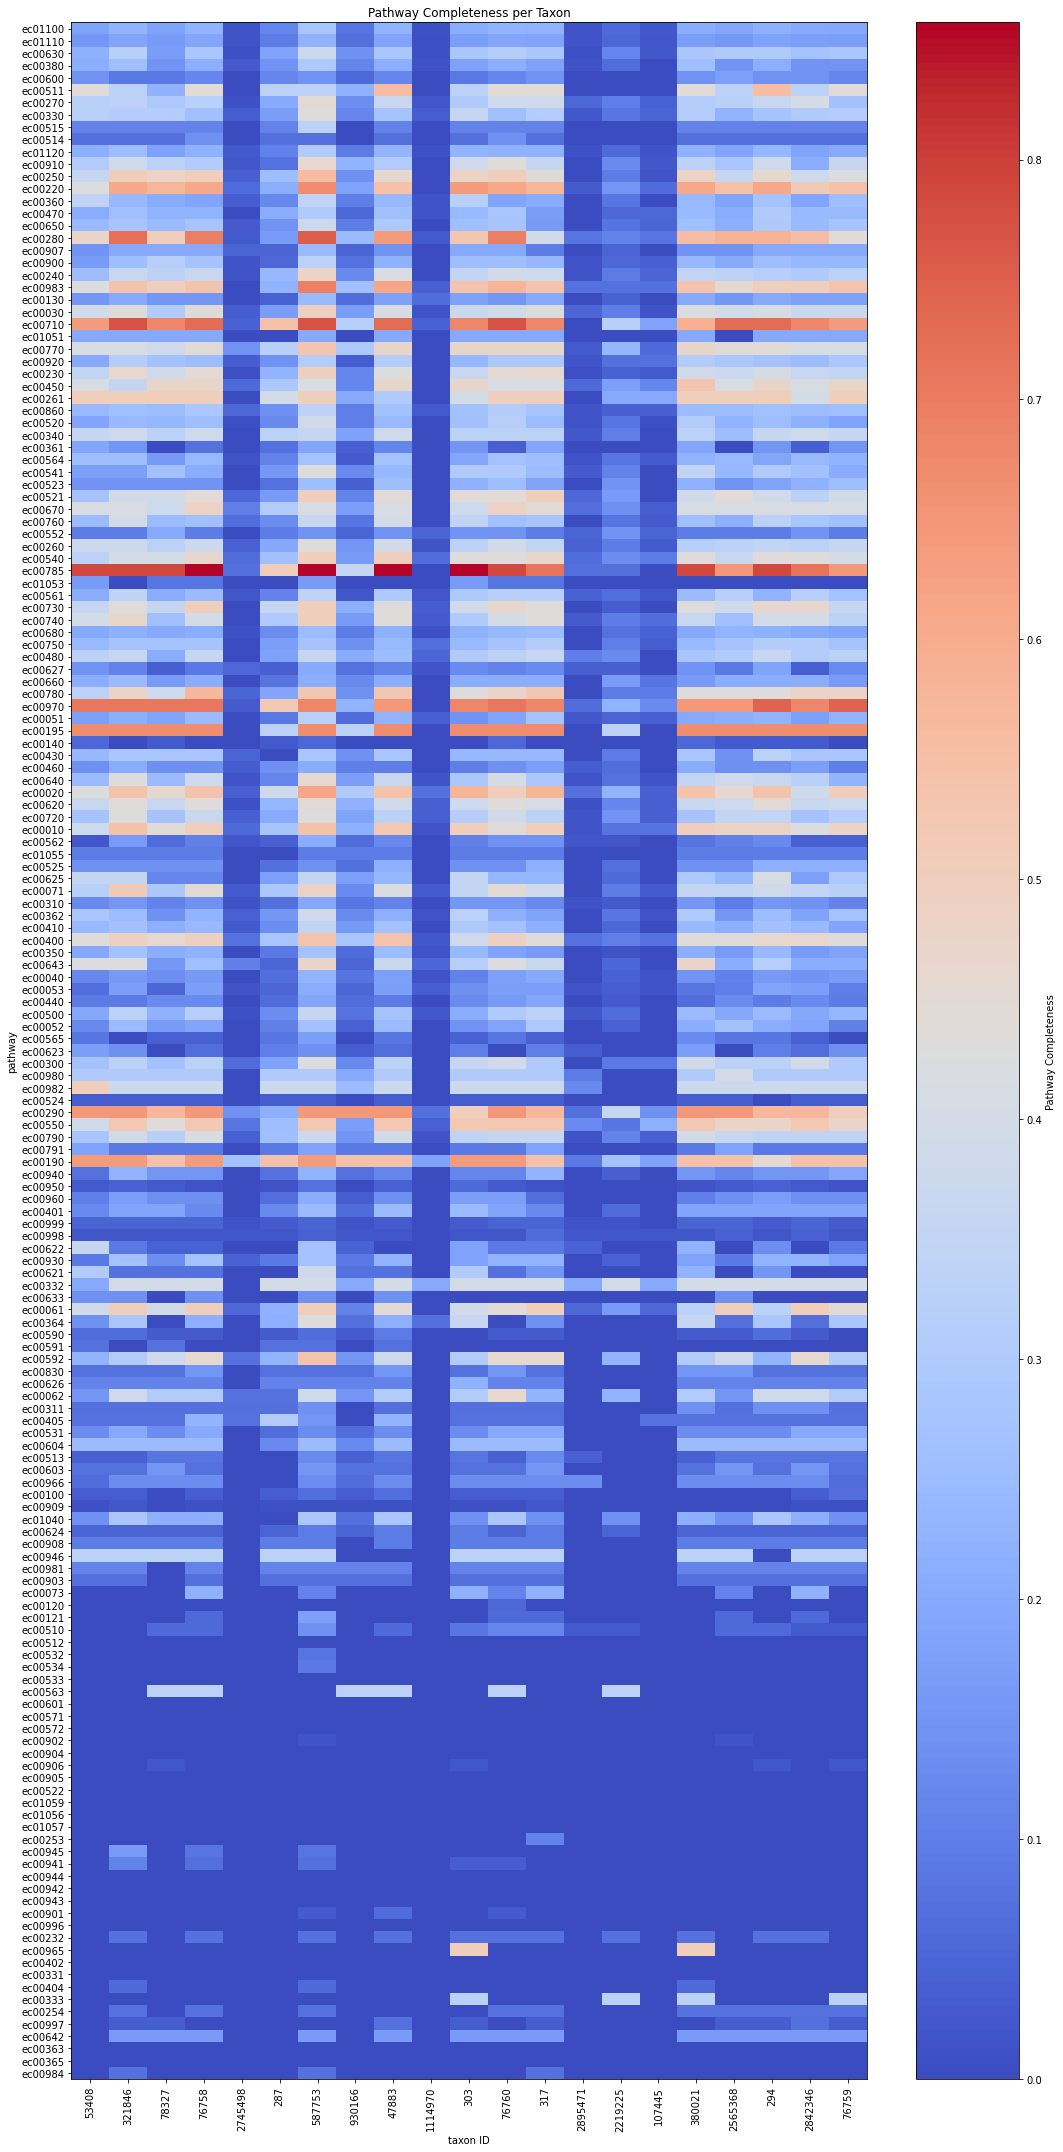

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

figure_output_dir = os.path.join(parent_dir, "figures")

# Read the CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")

# Extract pathway names and deepECs
pathways = df['pathway']
deepECs = df.columns[1:]

# Convert data to a numpy array
data = df.values[:, 1:].astype(float)

# Create a heatmap
plt.figure(figsize=(15, 30))
plt.imshow(data, cmap='coolwarm', aspect='auto')

# Set labels for axes
plt.xticks(np.arange(len(deepECs)), deepECs, rotation=90)
plt.yticks(np.arange(len(pathways)), pathways)

# Add color bar
plt.colorbar(label='Pathway Completeness')

# Show plot
plt.title('Pathway Completeness per Taxon')
plt.xlabel('taxon ID')
plt.ylabel('pathway')
plt.tight_layout()
plt.savefig(f"{figure_output_dir}/all_ec_pathway_completeness.png")
plt.show()


In [ ]:
# common pathways in Pseudomonas
pathway_numbers = [
    # 'ec00010', 
    # 'ec00020', 
    # # 'ec00030', 
    # # 'ec00910', 
    # 'ec00920', 
    # # 'ec00362', 
    # # 'ec00400', 
    # # 'ec02024'
    # # 'ec00300'
    # "ec00785",
    'ec00710'
]

# corresponding pathway names
pathway_names = [
    # 'Glycolysis / Gluconeogenesis', 
    # 'Citrate Cycle (TCA Cycle)', 
    # # 'Pentose Phosphate Pathway', 
    # # 'Nitrogen Metabolism', 
    # 'Sulfur Metabolism', 
    # # 'Benzoate Degradation', 
    # # 'Phenylalanine, Tyrosine and Tryptophan Biosynthesis', 
    # # 'Quorum Sensing',
    # # 'Lysine Biosynthesis',
    # 'Lipoic acid metabolism',
    'Carbon fixation in photosynthetic organisms'
]

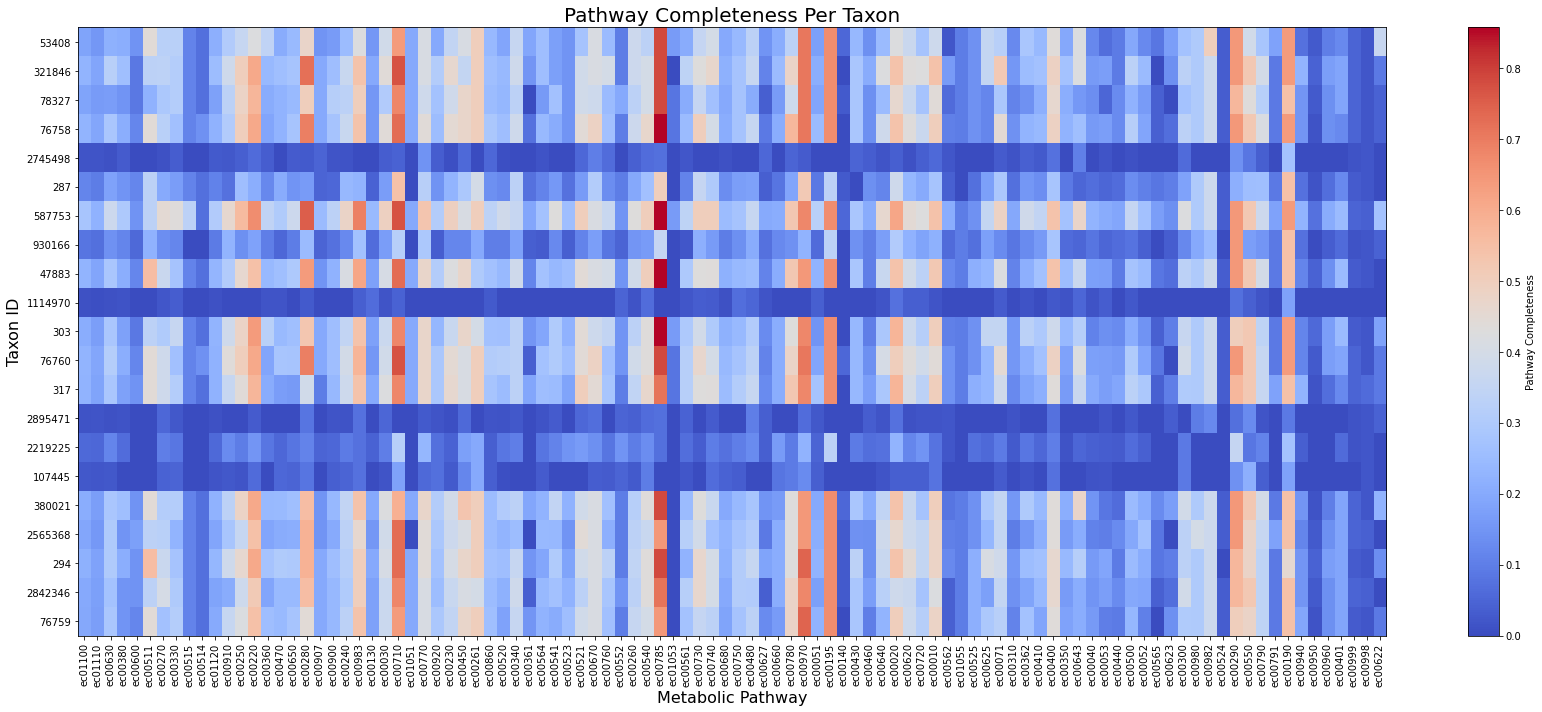

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# Read the modified CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")
df = df[0:100]

# Extract pathway names and deepECs
pathways = df.iloc[:, 0].values
deepECs = df.columns[1:]

# Convert data to a numpy array and transpose it
data = df.iloc[:, 1:].values.astype(float)
data = data.T

deepECs = [s.replace("deepEC_", "") for s in deepECs]


# Create a heatmap
plt.figure(figsize=(24, 10))
plt.imshow(data, cmap='coolwarm', aspect='auto')

# Set labels for axes
plt.yticks(np.arange(len(deepECs)), deepECs)
plt.xticks(np.arange(len(pathways)), pathways, rotation=90)

# Add color bar
plt.colorbar(label='Pathway Completeness')

# Show plot
plt.title('Pathway Completeness Per Taxon', fontsize=20)
plt.xlabel('Metabolic Pathway', fontsize=16)
plt.ylabel('Taxon ID', fontsize=16)
plt.tight_layout()
plt.savefig("pathway_completeness.png")  # Change the filename and format as needed
plt.show()


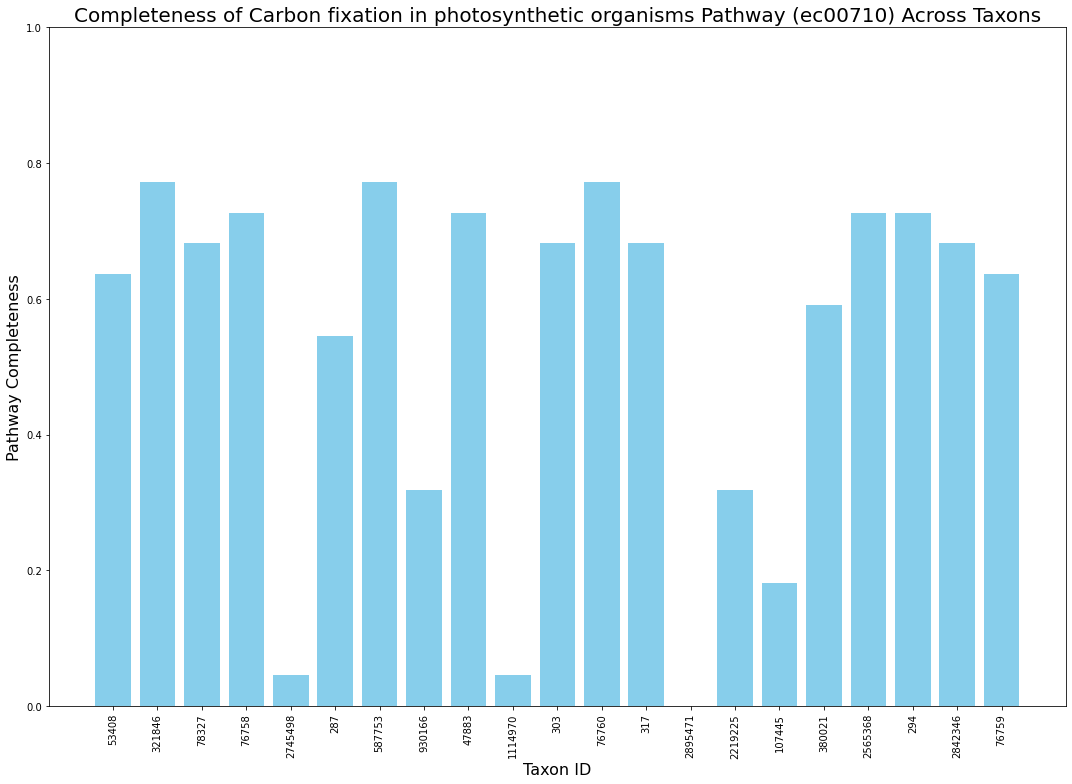

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("all_EC_pathway_completeness.csv")

for i in range(len(pathway_numbers)):
    try:
        curr_path = pathway_numbers[i]
        curr_name = pathway_names[i]
        
        # Choose the pathway for which you want to plot completeness
        chosen_pathway = curr_path  # Change this to your desired pathway

        # Extract the completeness values for the chosen pathway
        pathway_completeness = df[df['pathway'] == chosen_pathway].iloc[:, 1:].squeeze()

        # Get the taxon labels (deepECs)
        taxons = pathway_completeness.index

        # Create the bar plot
        plt.figure(figsize=(15, 11), facecolor='white')
        plt.bar(taxons, pathway_completeness, color='skyblue')

        # Add labels and title
        name = curr_name
        plt.title(f'Completeness of {name} Pathway ({chosen_pathway}) Across Taxons', fontsize=20)
        plt.xlabel('Taxon ID', fontsize=16)
        plt.ylabel('Pathway Completeness', fontsize=16)
        plt.ylim(0, 1.0)
        plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
        plt.tight_layout()

        plt.savefig(f"{parent_dir}/figures/pathway_plots/{chosen_pathway}_completeness.png")
        # Show the plot
        # plt.show()
    except ValueError as e:
        print(e)

In [ ]:
sub = df[["pathway", "587753"]]
sub[sub["pathway"] == "ec00785"]

,pathway,587753
44,ec00785,0.857143


In [ ]:
df[df["pathway"] == 'ec00785']

,pathway,53408,321846,78327,76758,2745498,287,587753,930166,47883,...,76760,317,2895471,2219225,107445,380021,2565368,294,2842346,76759
44,ec00785,0.785714,0.785714,0.785714,0.857143,0.071429,0.5,0.857143,0.357143,0.857143,...,0.785714,0.714286,0.071429,0.071429,0.0,0.785714,0.642857,0.785714,0.714286,0.642857
